In [1]:
import findspark
import imblearn

findspark.init()
import pyspark

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
# Disable warnings, set Matplotlib inline plotting and load Pandas package
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Importing DataSets

In [5]:
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
MAX_MEMORY = "5g"
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 30)
spark = SparkSession.builder.appName('Capstone Project 1').config("spark.executor.memory", MAX_MEMORY).config("spark.driver.memory", MAX_MEMORY).config("spark.storage.memoryFraction",1.0).config("spark.executor.cores",2).getOrCreate()
orders= spark.read.csv(r"D:\TN\Capstone\Datasets\orders.csv", header = True, inferSchema = True)
prior =spark.read.csv(r"D:\TN\Capstone\Datasets\order_products__prior.csv", header = True, inferSchema = True) 

In [6]:
#prior.show()

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import rank, col

window1 = Window.partitionBy(prior['order_id'])

prior = prior.select('order_id',F.max('add_to_cart_order').over(window1).alias("product_count")).dropDuplicates()



In [8]:
prior=prior.dropDuplicates()

In [9]:
#prior.show()

In [10]:
df = orders.join(prior, on = 'order_id', how='left')

In [11]:
#df.where(df["user_id"]==1).show()

In [12]:
#df_train=df.where(df["product_count"].isNull())

In [13]:
#df_train = df_train.select("user_id","days_since_prior_order")

In [14]:
#df=df.where(df["product_count"].isNotNull())

In [ ]:
print ("Rows     : " ,df.count())
print ("Columns  : " ,len(df.columns))

In [15]:
df.dtypes

[('order_id', 'int'),
 ('user_id', 'int'),
 ('eval_set', 'string'),
 ('order_number', 'int'),
 ('order_dow', 'int'),
 ('order_hour_of_day', 'int'),
 ('days_since_prior_order', 'double'),
 ('product_count', 'int')]

In [16]:
df = df.select('order_id','user_id','order_number','days_since_prior_order','product_count','order_dow','order_hour_of_day').dropDuplicates()


In [17]:
window1 = Window.partitionBy(df['user_id']).orderBy(df['order_number'].desc())
window2 = Window.partitionBy(df['user_id'])

In [18]:

df.dtypes

[('order_id', 'int'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('product_count', 'int'),
 ('order_dow', 'int'),
 ('order_hour_of_day', 'int')]

In [19]:
df = df.withColumn('rank',rank().over(window1))
df_train = df.filter(col('rank')==1)
df_train = df_train.select("user_id","days_since_prior_order")
df = df.where(df['rank']>1)


In [20]:
#df.show()

In [21]:
df=df.withColumn('total_orders', F.max('order_number').over(window2))
df=df.withColumn('visit_duration', F.sum('days_since_prior_order').over(window2))

In [22]:
col_1 = ['user_id','order_dow']
col_3 =['user_id','dow_count']
col_2 = ['user_id','order_hour_of_day']
col_4 =['user_id','hod_count']
window3 = Window.partitionBy([col(x) for x in col_1])
window4 = Window.partitionBy([col(x) for x in col_2])

df = df.withColumn('dow_count',F.count("order_dow").over(window3))
df = df.withColumn('hod_count',F.count("order_hour_of_day").over(window4))
df = df.orderBy(col_3, ascending=False).dropDuplicates()
df = df.withColumn("favorite_day_of_week",F.first("order_dow").over(window2))
df = df.orderBy(col_4, ascending=False).dropDuplicates()
df = df.withColumn("favorite_hour_of_day",F.first("order_hour_of_day").over(window2))


In [23]:
df.dtypes

[('order_id', 'int'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('product_count', 'int'),
 ('order_dow', 'int'),
 ('order_hour_of_day', 'int'),
 ('rank', 'int'),
 ('total_orders', 'int'),
 ('visit_duration', 'double'),
 ('dow_count', 'bigint'),
 ('hod_count', 'bigint'),
 ('favorite_day_of_week', 'int'),
 ('favorite_hour_of_day', 'int')]

In [24]:
df = df.filter(col('total_orders')>3)

In [25]:


df_2=df.filter(col('rank')<= 11)
df_2=df_2.withColumn('avg_prod_count', F.round(F.avg("product_count").over(window2)))



In [26]:
df.dtypes

[('order_id', 'int'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('product_count', 'int'),
 ('order_dow', 'int'),
 ('order_hour_of_day', 'int'),
 ('rank', 'int'),
 ('total_orders', 'int'),
 ('visit_duration', 'double'),
 ('dow_count', 'bigint'),
 ('hod_count', 'bigint'),
 ('favorite_day_of_week', 'int'),
 ('favorite_hour_of_day', 'int')]

In [26]:
#df_2=df_2.withColumn('avg_prod_count_scaled', (df_2['avg_prod_count']-3))

In [27]:
#df_2.where(col('total_orders')>3).show()


In [28]:
#df_2 = df_2.select("user_id","avg_prod_count_scaled")

In [29]:
#df_3 = df.join(df_2,on='user_id',how='inner')

In [27]:
df_3 = df_2.select("order_id","user_id","order_number","days_since_prior_order","product_count","avg_prod_count","total_orders","visit_duration","rank","favorite_day_of_week","favorite_hour_of_day").dropDuplicates()

In [31]:
#df_3 = df_3.where(df_3['product_count']>=df_3['avg_prod_count_scaled'])

In [32]:
#df_3 = df_3.withColumn('rank',rank().over(window1))
#df_3=df_3.filter(col('rank')<= 10)

In [28]:
#data cleaning
df_3 = df_3.where(df_3['days_since_prior_order']!=0)
df_3 = df_3.where(df_3['days_since_prior_order'].isNotNull()) 

In [29]:
df_3=df_3.withColumn('frequency', F.round(F.avg('days_since_prior_order').over(window2)))

In [30]:
df_3 = df_3.filter(col('total_orders')>3)

In [31]:
window3=Window.partitionBy('user_id').orderBy('rank')
df_3=df_3.withColumn("recency",F.first("days_since_prior_order").over(window3))
df_3 = df_3.filter(col("rank")>2)
df_3=df_3.withColumn("days_since_prior_1_order",F.first("days_since_prior_order").over(window3))
df_3 = df_3.filter(col("rank")>3)
df_3=df_3.withColumn("days_since_prior_2_order",F.first("days_since_prior_order").over(window3))


In [32]:
df_3 = df_3.withColumn("latest_order_product_count", F.first("product_count").over(window3))

In [33]:
df_3.dtypes

[('order_id', 'int'),
 ('user_id', 'int'),
 ('order_number', 'int'),
 ('days_since_prior_order', 'double'),
 ('product_count', 'int'),
 ('avg_prod_count', 'double'),
 ('total_orders', 'int'),
 ('visit_duration', 'double'),
 ('rank', 'int'),
 ('favorite_day_of_week', 'int'),
 ('favorite_hour_of_day', 'int'),
 ('frequency', 'double'),
 ('recency', 'double'),
 ('days_since_prior_1_order', 'double'),
 ('days_since_prior_2_order', 'double'),
 ('latest_order_product_count', 'int')]

In [35]:
df_3.toPandas().to_csv("user_order_data.csv")

In [39]:
df_3 = df_3.drop("order_id","order_number","days_since_prior_order","product_count","rank").dropDuplicates()

In [40]:
df_3.dtypes

[('user_id', 'int'),
 ('avg_prod_count', 'double'),
 ('total_orders', 'int'),
 ('visit_duration', 'double'),
 ('favorite_day_of_week', 'int'),
 ('favorite_hour_of_day', 'int'),
 ('frequency', 'double'),
 ('recency', 'double'),
 ('days_since_prior_1_order', 'double'),
 ('days_since_prior_2_order', 'double'),
 ('latest_order_product_count', 'int')]

In [41]:
df = df_3.join(df_train, on = 'user_id', how='inner').dropDuplicates()

In [42]:
df.cache()

DataFrame[user_id: int, avg_prod_count: double, total_orders: int, visit_duration: double, favorite_day_of_week: int, favorite_hour_of_day: int, frequency: double, recency: double, days_since_prior_1_order: double, days_since_prior_2_order: double, latest_order_product_count: int, days_since_prior_order: double]

In [44]:
#print ("Rows     : " ,df.count())
#print ("Columns  : " ,len(df.columns))

In [45]:
df = df.dropDuplicates()

In [46]:
df.toPandas().to_csv("final_prediction_1.csv")

In [ ]:
from pyspark.sql.types import StringType
# Converting label days_since_prior_order to categorical column
def purchase_interval(r):
    if r <= 15:
        return "Class0"
    elif r > 15:
        return "Class1"


ol_val = udf(purchase_interval, StringType())

df = df.withColumn("purchase_interval",F.lit(ol_val(df.days_since_prior_order)))
df = df.withColumn("prior_1_purchase_interval",F.lit(ol_val(df.recency)))
df = df.withColumn("prior_2_purchase_interval",F.lit(ol_val(df.days_since_prior_1_order)))
df = df.withColumn("prior_3_purchase_interval",F.lit(ol_val(df.days_since_prior_2_order)))


In [ ]:
#removing outliers (visit duration should be atleast 2 times greater than the total orders as frequency usually won't be 1 day or 0 day)
df = df.filter(col('visit_duration')>(2*col('total_orders')))

In [47]:
#checking for missing values
print(df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose())
#df = df.na.fill(30)
#print(df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().transpose())

                            0
user_id                     0
avg_prod_count              0
total_orders                0
visit_duration              0
favorite_day_of_week        0
favorite_hour_of_day        0
frequency                   0
recency                     0
days_since_prior_1_order    0
days_since_prior_2_order    0
latest_order_product_count  0
days_since_prior_order      0
purchase_interval           0
prior_1_purchase_interval   0
prior_2_purchase_interval   0
prior_3_purchase_interval   0


In [48]:
df.dtypes

[('user_id', 'int'),
 ('avg_prod_count', 'double'),
 ('total_orders', 'int'),
 ('visit_duration', 'double'),
 ('favorite_day_of_week', 'int'),
 ('favorite_hour_of_day', 'int'),
 ('frequency', 'double'),
 ('recency', 'double'),
 ('days_since_prior_1_order', 'double'),
 ('days_since_prior_2_order', 'double'),
 ('latest_order_product_count', 'int'),
 ('days_since_prior_order', 'double'),
 ('purchase_interval', 'string'),
 ('prior_1_purchase_interval', 'string'),
 ('prior_2_purchase_interval', 'string'),
 ('prior_3_purchase_interval', 'string')]

In [49]:

r_quartile = df.approxQuantile("recency", [0.25, 0.5, 0.75], 0)
f_quartile = df.approxQuantile("frequency", [0.25, 0.5, 0.75], 0)
e_quartile = df.approxQuantile("visit_duration", [0.25, 0.5, 0.75], 0)

In [50]:
from pyspark.sql.functions import when,concat
df = df.withColumn("r_quartile", when(col("Recency") >= r_quartile[2] , 1).when(col("Recency") >= r_quartile[1] , 2).when(col("Recency") >= r_quartile[0] , 3).otherwise(4))
df = df.withColumn("f_quartile", when(col("Frequency") >= f_quartile[2] , 1).when(col("Frequency") >= f_quartile[1] , 2).when(col("Frequency") >= f_quartile[0] , 3).otherwise(4))
df = df.withColumn("e_quartile", when(col("Visit_duration") >= e_quartile[2] , 1).when(col("Visit_duration") >= e_quartile[1] , 2).when(col("Visit_duration") >= e_quartile[0] , 3).otherwise(4))


df = df.withColumn("RFE_Score", concat(col("r_quartile"), col("f_quartile"), col("e_quartile")))


In [51]:
'''dataset_size= df.count()
l0=df.select("purchase_interval").where(df['purchase_interval'] == 'Class0').count()
l1=dataset_size-l0

print("class0: ",l0)
print("class1: ",l1)
'''

'dataset_size= df.count()\nl0=df.select("purchase_interval").where(df[\'purchase_interval\'] == \'Class0\').count()\nl1=dataset_size-l0\n\nprint("class0: ",l0)\nprint("class1: ",l1)\n'

In [52]:
#df = df.select("user_id","recency","frequency","total_orders","visit_duration","r_quartile","f_quartile","e_quartile","RFE_Score","prior_1_purchase_interval","prior_2_purchase_interval","prior_3_purchase_interval","days_since_prior_1_order","days_since_prior_2_order","purchase_interval","days_since_prior_order")

In [53]:
#df.show(5)

In [54]:

df_p = df.toPandas()

In [60]:
df_p.shape

(181386, 20)

In [56]:
df_p.keys()

Index(['user_id', 'avg_prod_count', 'total_orders', 'visit_duration', 'favorite_day_of_week', 'favorite_hour_of_day', 'frequency', 'recency', 'days_since_prior_1_order', 'days_since_prior_2_order', 'latest_order_product_count', 'days_since_prior_order', 'purchase_interval', 'prior_1_purchase_interval', 'prior_2_purchase_interval', 'prior_3_purchase_interval', 'r_quartile', 'f_quartile',
       'e_quartile', 'RFE_Score'],
      dtype='object')

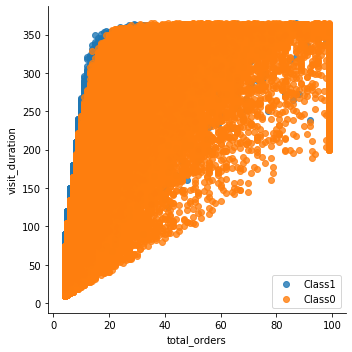

In [57]:
import seaborn as sns
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="total_orders", y="visit_duration", data=df_p, fit_reg=False, hue='prior_1_purchase_interval', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')


In [58]:
# label encoding the data 
from sklearn.preprocessing import LabelEncoder 
  
le = LabelEncoder() 
  


df_p['prior_1_purchase_interval']= le.fit_transform(df_p['prior_1_purchase_interval']) 
df_p['purchase_interval']= le.fit_transform(df_p['purchase_interval']) 
df_p['prior_2_purchase_interval']= le.fit_transform(df_p['prior_2_purchase_interval']) 
df_p['prior_3_purchase_interval']= le.fit_transform(df_p['prior_3_purchase_interval']) 
df_p['RFE_Score'] = le.fit_transform(df_p['RFE_Score'])

In [61]:
import numpy as np
df_p['total_orders_log'] = np.log(df_p.total_orders)
df_p['visit_duration_log'] = np.log(df_p.visit_duration)
df_p['avg_product_count_log'] = np.log(df_p.avg_prod_count)
df_p['latest_order_product_count_log'] = np.log(df_p.latest_order_product_count)


In [62]:
cols = df_p.columns.tolist()
cols

['user_id',
 'avg_prod_count',
 'total_orders',
 'visit_duration',
 'favorite_day_of_week',
 'favorite_hour_of_day',
 'frequency',
 'recency',
 'days_since_prior_1_order',
 'days_since_prior_2_order',
 'latest_order_product_count',
 'days_since_prior_order',
 'purchase_interval',
 'prior_1_purchase_interval',
 'prior_2_purchase_interval',
 'prior_3_purchase_interval',
 'r_quartile',
 'f_quartile',
 'e_quartile',
 'RFE_Score',
 'total_orders_log',
 'visit_duration_log',
 'avg_product_count_log',
 'latest_order_product_count_log']

In [63]:
cols = ['user_id',
 'avg_prod_count',
 'total_orders',
 'visit_duration',
 'favorite_day_of_week',
 'favorite_hour_of_day',
 'frequency',
 'recency',
 'days_since_prior_1_order',
 'days_since_prior_2_order',
 'latest_order_product_count',
 'days_since_prior_order',
 'prior_1_purchase_interval',
 'prior_2_purchase_interval',
 'prior_3_purchase_interval',
 'r_quartile',
 'f_quartile',
 'e_quartile',
 'RFE_Score',
 'total_orders_log',
 'visit_duration_log',
 'avg_product_count_log',
 'latest_order_product_count_log',
 'purchase_interval']

In [64]:
df_p = df_p[cols]
cols


['user_id',
 'avg_prod_count',
 'total_orders',
 'visit_duration',
 'favorite_day_of_week',
 'favorite_hour_of_day',
 'frequency',
 'recency',
 'days_since_prior_1_order',
 'days_since_prior_2_order',
 'latest_order_product_count',
 'days_since_prior_order',
 'prior_1_purchase_interval',
 'prior_2_purchase_interval',
 'prior_3_purchase_interval',
 'r_quartile',
 'f_quartile',
 'e_quartile',
 'RFE_Score',
 'total_orders_log',
 'visit_duration_log',
 'avg_product_count_log',
 'latest_order_product_count_log',
 'purchase_interval']

In [65]:
data = df_p.drop(['days_since_prior_order','total_orders','visit_duration','avg_prod_count','latest_order_product_count'],axis =1)

In [66]:
data.keys()

Index(['user_id', 'favorite_day_of_week', 'favorite_hour_of_day', 'frequency', 'recency', 'days_since_prior_1_order', 'days_since_prior_2_order', 'prior_1_purchase_interval', 'prior_2_purchase_interval', 'prior_3_purchase_interval', 'r_quartile', 'f_quartile', 'e_quartile', 'RFE_Score', 'total_orders_log', 'visit_duration_log', 'avg_product_count_log', 'latest_order_product_count_log',
       'purchase_interval'],
      dtype='object')

In [67]:
data.describe()

,user_id,favorite_day_of_week,favorite_hour_of_day,frequency,recency,days_since_prior_1_order,days_since_prior_2_order,prior_1_purchase_interval,prior_2_purchase_interval,prior_3_purchase_interval,r_quartile,f_quartile,e_quartile,RFE_Score,total_orders_log,visit_duration_log,avg_product_count_log,latest_order_product_count_log,purchase_interval
count,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000,181386.000000
mean,103154.640954,2.485037,12.665983,14.902523,15.826067,15.255091,14.922001,0.436081,0.412110,0.397010,2.474971,2.448265,2.497729,30.890317,2.493562,4.940680,2.139356,2.028896,0.470185
std,59519.795007,2.139362,3.899291,6.804205,10.220146,10.060850,10.012101,0.495899,0.492216,0.489279,1.099772,1.099256,1.118779,20.436349,0.803405,0.697365,0.646096,0.840828,0.499112
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.386294,2.197225,0.000000,0.000000,0.000000
25%,51638.000000,1.000000,10.000000,9.000000,7.000000,7.000000,7.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,11.000000,1.791759,4.477337,1.791759,1.609438,0.000000
50%,103183.500000,2.000000,12.000000,15.000000,14.000000,13.000000,12.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,31.000000,2.397895,5.023881,2.197225,2.079442,0.000000
75%,154704.750000,4.000000,15.000000,20.000000,29.000000,27.000000,26.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,47.000000,3.044522,5.533389,2.564949,2.639057,1.000000
max,206209.000000,6.000000,23.000000,30.000000,30.000000,30.000000,30.000000,1.000000,1.000000,1.000000,4.000000,4.000000,4.000000,63.000000,4.595120,5.899897,4.143135,4.624973,1.000000


In [68]:
data.head()

,user_id,favorite_day_of_week,favorite_hour_of_day,frequency,recency,days_since_prior_1_order,days_since_prior_2_order,prior_1_purchase_interval,prior_2_purchase_interval,prior_3_purchase_interval,r_quartile,f_quartile,e_quartile,RFE_Score,total_orders_log,visit_duration_log,avg_product_count_log,latest_order_product_count_log,purchase_interval
0,148,6,13,7.0,30.0,1.0,3.0,1,0,0,1,4,4,15,1.945910,3.737670,2.708050,2.708050,1
1,463,1,17,18.0,4.0,17.0,30.0,0,1,1,4,2,3,54,1.945910,4.682131,2.484907,2.995732,1
2,471,0,14,11.0,16.0,5.0,16.0,1,0,1,2,3,4,27,1.791759,4.007333,3.044522,3.091042,0
3,496,3,12,2.0,1.0,2.0,1.0,0,0,0,4,4,1,60,4.406719,5.627621,1.609438,1.609438,0
4,833,1,12,21.0,30.0,6.0,13.0,1,0,0,1,1,2,1,2.397895,5.351858,2.995732,2.639057,1


from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials = pd.DataFrame(poly.fit_transform(data_X))

data_1 = pd.concat([data, polynomials], axis=1)

data_1= data_1.drop([0,1,2,3,4,5],axis=1)

data_1.head(5)

In [69]:
len(data.keys())

19

In [140]:
features = ['user_id', 'avg_product_count_log', 'total_orders_log', 'visit_duration_log', 'favorite_day_of_week', 'favorite_hour_of_day', 'frequency', 'recency', 'days_since_prior_1_order', 'days_since_prior_2_order', 'latest_order_product_count_log', 'prior_1_purchase_interval', 'prior_2_purchase_interval', 'prior_3_purchase_interval', 'r_quartile', 'f_quartile', 'e_quartile', 'RFE_Score']
target = ['purchase_interval']

In [70]:
array = data.values
X = array[:,0:18]
y = array[:,18]

In [71]:
y

array([1., 1., 0., ..., 1., 1., 1.])

In [72]:
from collections import Counter
counter = Counter(y)
print("class0: ",counter[0.])
print("class1: ",counter[1.])

class0:  96101
class1:  85285


In [73]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)


In [74]:
X

array([[-1.73063306,  1.64299986,  0.08566118, ..., -1.72508588,
         0.88020268,  0.8077239 ],
       [-1.72534069, -0.69415143,  1.11149145, ..., -0.37075232,
         0.53482984,  1.14986643],
       [-1.72520628, -1.16158169,  0.34211874, ..., -1.33839529,
         1.40098121,  1.26321957],
       ...,
       [ 1.72874659,  0.24070909,  1.11149145, ..., -1.33839529,
        -0.53799618, -0.09869521],
       [ 1.73002348, -0.22672117,  0.08566118, ...,  0.83854924,
        -0.29940781,  0.54233753],
       [ 1.73124997,  1.1755696 ,  0.85503388, ..., -0.51008263,
        -0.53799618, -0.49886427]])

In [ ]:
from collections import Counter
counter = Counter(y)
print(counter)

In [97]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [100]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb= XGBClassifier(random_state = 1,scale_pos_weight = 0.9, max_depth = 8)
xgbmodel = xgb.fit(X_train, Y_train)
prediction_1 = xgbmodel.predict(X_train)

# Evaluate predictions
print(metrics.accuracy_score(Y_train, prediction_1))
print(metrics.confusion_matrix(Y_train, prediction_1))
print(metrics.classification_report(Y_train, prediction_1))

0.702042616533892
[[51539 25365]
 [17871 50333]]
              precision    recall  f1-score   support

         0.0       0.74      0.67      0.70     76904
         1.0       0.66      0.74      0.70     68204

    accuracy                           0.70    145108
   macro avg       0.70      0.70      0.70    145108
weighted avg       0.71      0.70      0.70    145108



In [101]:
prediction_2 = xgbmodel.predict(X_test)
# Evaluate predictions
print(metrics.accuracy_score(Y_test, prediction_2))
print(metrics.confusion_matrix(Y_test, prediction_2))
print(metrics.classification_report(Y_test, prediction_2))

0.6999834610507746
[[12754  6443]
 [ 4441 12640]]
              precision    recall  f1-score   support

         0.0       0.74      0.66      0.70     19197
         1.0       0.66      0.74      0.70     17081

    accuracy                           0.70     36278
   macro avg       0.70      0.70      0.70     36278
weighted avg       0.70      0.70      0.70     36278



In [102]:
# make predictions for test data and evaluate
accuracy = metrics.accuracy_score(Y_test, prediction_2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.00%


[0.02680067 0.0201005  0.02847571 0.14070351 0.05527638 0.06700168
 0.05695142 0.         0.         0.         0.         0.
 0.         0.04355109 0.1524288  0.2964824  0.05862647 0.05360134]


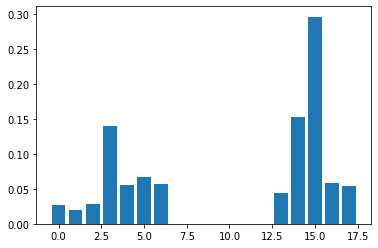

In [103]:
import matplotlib.pyplot as plt
# feature importance
print(xgbmodel.feature_importances_)
# plot
plt.bar(range(len(xgbmodel.feature_importances_)), xgbmodel.feature_importances_)
plt.show()

In [104]:
features = ['user_id', 'avg_prod_count', 'total_orders', 'visit_duration', 'favorite_day_of_week', 'favorite_hour_of_day', 'frequency', 'recency', 'days_since_prior_1_order', 'days_since_prior_2_order', 'latest_order_product_count', 'prior_1_purchase_interval', 'prior_2_purchase_interval', 'prior_3_purchase_interval', 'r_quartile', 'f_quartile', 'e_quartile', 'RFE_Score']
target = ['purchase_interval']

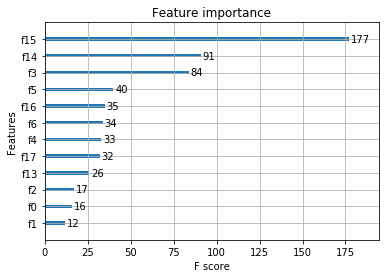

In [105]:
from xgboost import plot_importance
# plot feature importance
plot_importance(xgbmodel)
plt.show()


In [106]:
import xgboost as xgb

xgb.__version__

'0.80'

In [87]:
# Fit model using each importance as a threshold

from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
thresholds = sort(xgbmodel.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(xgbmodel, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, Y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(Y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.000, n=18, Accuracy: 70.00%
Thresh=0.020, n=12, Accuracy: 70.00%
Thresh=0.027, n=11, Accuracy: 69.95%
Thresh=0.028, n=10, Accuracy: 69.95%
Thresh=0.044, n=9, Accuracy: 70.01%
Thresh=0.054, n=8, Accuracy: 69.94%
Thresh=0.055, n=7, Accuracy: 69.90%
Thresh=0.057, n=6, Accuracy: 69.09%
Thresh=0.059, n=5, Accuracy: 69.02%
Thresh=0.067, n=4, Accuracy: 68.93%
Thresh=0.141, n=3, Accuracy: 68.76%
Thresh=0.152, n=2, Accuracy: 68.42%
Thresh=0.296, n=1, Accuracy: 61.26%


In [130]:

from sklearn import metrics
xgb= XGBClassifier(random_state = 1, threshold = 0.044,scale_pos_weight=0.9,max_depth = 8)
xgbmodel = xgb.fit(X_train, Y_train)
prediction_1 = xgbmodel.predict(X_train)

# Evaluate predictions
print(metrics.accuracy_score(Y_train, prediction_1))
print(metrics.confusion_matrix(Y_train, prediction_1))
print(metrics.classification_report(Y_train, prediction_1))

0.7208906469663975
[[55422 21482]
 [19019 49185]]
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73     76904
         1.0       0.70      0.72      0.71     68204

    accuracy                           0.72    145108
   macro avg       0.72      0.72      0.72    145108
weighted avg       0.72      0.72      0.72    145108



In [131]:
prediction_2 = xgbmodel.predict(X_test)
# Evaluate predictions
print(metrics.accuracy_score(Y_test, prediction_2))
print(metrics.confusion_matrix(Y_test, prediction_2))
print(metrics.classification_report(Y_test, prediction_2))

0.7003142400352831
[[13444  5753]
 [ 5119 11962]]
              precision    recall  f1-score   support

         0.0       0.72      0.70      0.71     19197
         1.0       0.68      0.70      0.69     17081

    accuracy                           0.70     36278
   macro avg       0.70      0.70      0.70     36278
weighted avg       0.70      0.70      0.70     36278



In [133]:
#evaluation using K-fold crossvalidation
# CV model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold = KFold(n_splits=10, random_state=1)
results = cross_val_score(xgbmodel, X_train, Y_train, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 69.89% (0.49%)


In [134]:
prediction_together = xgbmodel.predict(X)
probability = xgbmodel.predict_proba(X)
# Evaluate predictions
print(metrics.accuracy_score(y, prediction_together))
print(metrics.confusion_matrix(y, prediction_together))
print(metrics.classification_report(y, prediction_together))

0.7167752748282668
[[68866 27235]
 [24138 61147]]
              precision    recall  f1-score   support

         0.0       0.74      0.72      0.73     96101
         1.0       0.69      0.72      0.70     85285

    accuracy                           0.72    181386
   macro avg       0.72      0.72      0.72    181386
weighted avg       0.72      0.72      0.72    181386



In [135]:
prediction = prediction_together.tolist()
probabilities = probability.tolist()


In [136]:
data['prediction_purchase_interval'] = prediction
data['probability'] = probabilities

In [148]:
data_1 = data[data["purchase_interval"] != data["prediction_purchase_interval"]]
data_1[['user_id','frequency','recency','purchase_interval','prediction_purchase_interval','probability']]


,user_id,frequency,recency,purchase_interval,prediction_purchase_interval,probability
6,1238,11.0,8.0,1,0.0,"[0.66220623254776, 0.33779376745224]"
7,1342,7.0,2.0,1,0.0,"[0.6062015295028687, 0.39379850029945374]"
8,1580,22.0,30.0,0,1.0,"[0.3222254514694214, 0.6777745485305786]"
20,3918,20.0,14.0,0,1.0,"[0.3916028141975403, 0.6083971858024597]"
21,4101,14.0,10.0,0,1.0,"[0.49824708700180054, 0.5017529129981995]"
...,...,...,...,...,...,...
181357,198617,30.0,30.0,0,1.0,"[0.2280600666999817, 0.7719399333000183]"
181360,199524,16.0,22.0,0,1.0,"[0.405803382396698, 0.594196617603302]"
181368,201024,9.0,30.0,1,0.0,"[0.5466443300247192, 0.4533556401729584]"
181378,203543,16.0,21.0,0,1.0,"[0.4363967776298523, 0.5636032223701477]"


In [149]:
data_1.corr()

,user_id,favorite_day_of_week,favorite_hour_of_day,frequency,recency,days_since_prior_1_order,days_since_prior_2_order,prior_1_purchase_interval,prior_2_purchase_interval,prior_3_purchase_interval,r_quartile,f_quartile,e_quartile,RFE_Score,total_orders_log,visit_duration_log,avg_product_count_log,latest_order_product_count_log,purchase_interval,prediction_purchase_interval
user_id,1.000000,-0.004359,0.001314,0.003790,0.002566,0.003382,0.003320,0.004122,0.002773,0.001939,-0.002600,-0.003469,0.003759,-0.002779,-0.004226,-0.003583,-0.001523,-0.000777,0.003031,0.004962
favorite_day_of_week,-0.004359,1.000000,-0.000614,-0.000171,-0.000427,-0.000178,-0.000152,0.003794,0.003607,0.003884,0.003380,0.003432,0.047449,0.006247,-0.034015,-0.049379,-0.061591,-0.050224,0.002879,0.008535
favorite_hour_of_day,0.001314,-0.000614,1.000000,-0.012349,0.000158,-0.002820,-0.006509,0.001934,-0.000221,-0.004172,0.002454,0.005382,-0.045792,0.000764,0.039362,0.050170,0.041546,0.032695,0.001486,0.000303
frequency,0.003790,-0.000171,-0.012349,1.000000,0.651389,0.673091,0.678301,0.582267,0.597312,0.601535,-0.632761,-0.949135,0.167209,-0.739886,-0.598335,-0.063593,-0.083791,-0.081886,0.425175,0.759184
recency,0.002566,-0.000427,0.000158,0.651389,1.000000,0.396098,0.352003,0.904542,0.349775,0.310046,-0.957798,-0.620645,0.115961,-0.951882,-0.391747,-0.041780,-0.061229,-0.073895,0.342317,0.649391
days_since_prior_1_order,0.003382,-0.000178,-0.002820,0.673091,0.396098,1.000000,0.390925,0.353759,0.901044,0.344243,-0.385883,-0.640901,0.096761,-0.464855,-0.386595,-0.024410,-0.062064,-0.070422,0.315066,0.593918
days_since_prior_2_order,0.003320,-0.000152,-0.006509,0.678301,0.352003,0.390925,1.000000,0.313241,0.346763,0.900631,-0.344763,-0.644313,0.092878,-0.430396,-0.387586,-0.022883,-0.056465,-0.021283,0.294995,0.541502
prior_1_purchase_interval,0.004122,0.003794,0.001934,0.582267,0.904542,0.353759,0.313241,1.000000,0.321644,0.280548,-0.842410,-0.560156,0.096481,-0.840582,-0.338874,-0.029625,-0.065352,-0.074799,0.308609,0.601677
prior_2_purchase_interval,0.002773,0.003607,-0.000221,0.597312,0.349775,0.901044,0.346763,0.321644,1.000000,0.314724,-0.336013,-0.574128,0.079834,-0.408475,-0.332272,-0.015646,-0.067505,-0.075266,0.282853,0.544591
prior_3_purchase_interval,0.001939,0.003884,-0.004172,0.601535,0.310046,0.344243,0.900631,0.280548,0.314724,1.000000,-0.300418,-0.576336,0.076409,-0.378490,-0.332793,-0.014107,-0.064899,-0.038342,0.262919,0.488833
